In [130]:
import os
import datetime
import time

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import TimeseriesGenerator


mpl.rcParams['figure.figsize'] = (20, 8)
mpl.rcParams['axes.grid'] = False
plt.style.use('ggplot')

In [131]:

data_2 = pd.read_csv('../output/zero4_outputs.csv')
data_2 = data_2.drop([data_2.columns[0]], axis='columns')
data_2 = data_2.iloc[:, :-3]
data_2.reset_index(drop=True, inplace=True)
# unit='s' to convert it into epoch time
data_2['Time'] = pd.to_datetime(data_2['Time'])

date_time = data_2['Time'].dt.strftime('%S')


# checking our dataframe once again
data_2.head()


,Time,Subcar_0,Subcar_1,Subcar_2,Subcar_3,Subcar_4,Subcar_5,Subcar_6,Subcar_7,Subcar_8,...,Subcar_49,Subcar_50,Subcar_51,Subcar_52,Subcar_53,Subcar_54,Subcar_55,Subcar_56,Subcar_57,Subcar_58
0,1970-01-01 00:00:01.641598542,5499.938181,7461.867126,6230.129694,8741.921642,297.127919,327.200244,362.527240,353.411941,351.432782,...,575.782077,520.239368,471.936436,437.649403,412.093436,393.782935,396.807258,398.600050,399.450873,405.544079
1,1970-01-01 00:00:01.641598543,5499.938181,7461.867126,6230.129694,8741.921642,350.910245,340.565706,338.013313,332.434956,327.232333,...,455.247186,423.709806,390.858030,367.766230,339.484904,339.087010,343.083080,343.739727,346.943800,351.039884
2,1970-01-01 00:00:01.641598544,5499.938181,7461.867126,6230.129694,8741.921642,357.572370,389.307077,421.911128,424.001179,447.754397,...,672.899695,599.141052,524.108767,466.309983,418.119600,397.935924,387.985824,371.260017,354.983098,338.710791
3,1970-01-01 00:00:01.641598545,5499.938181,7461.867126,6230.129694,8741.921642,507.385455,518.653063,533.348854,545.424605,542.492396,...,610.351538,538.108725,508.141712,459.243944,413.706418,406.503382,392.998728,389.802514,381.072172,390.508643
4,1970-01-01 00:00:01.641598546,5499.938181,7461.867126,6230.129694,8741.921642,379.117396,397.553770,415.226444,450.480854,445.583887,...,788.428817,729.188590,698.148981,653.314626,626.906692,633.941638,639.366092,651.254942,668.481862,671.060355


Text(0, 0.5, 'Amplitude')

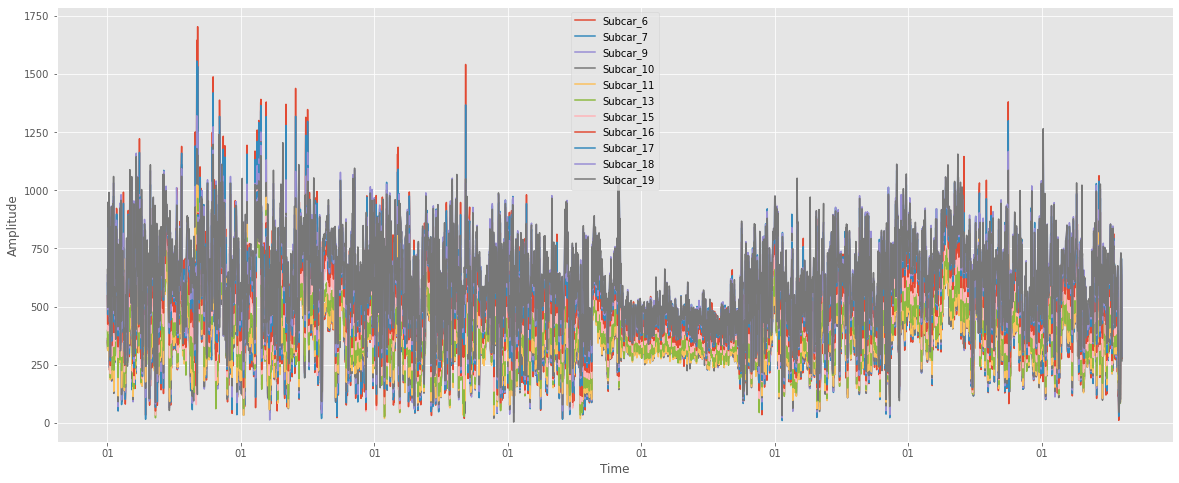

In [132]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_9',
             'Subcar_10', 'Subcar_11', 'Subcar_13', 'Subcar_15', 'Subcar_16', 'Subcar_17', 'Subcar_18', 'Subcar_19']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude")


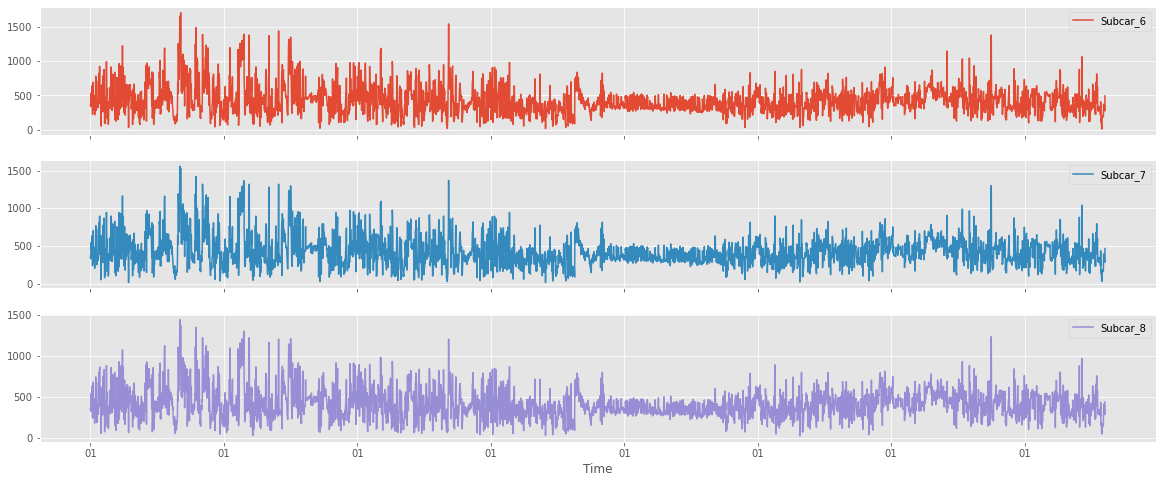

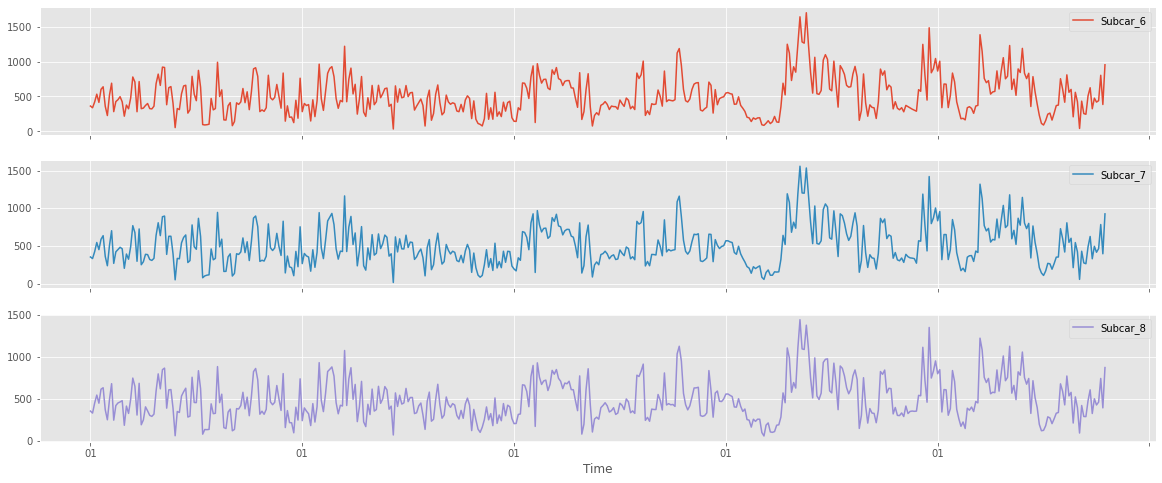

In [133]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_8']
plot_features = data_2[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=True)

plot_features = data_2[plot_cols][:480]
plot_features.index = date_time[:480]
_ = plot_features.plot(subplots=True)


In [134]:
# Set the date column as the index of your DataFrame meat
data_2 = data_2.set_index('Time')

# Print the summary statistics of the DataFrame
print(data_2.describe())


          Subcar_0     Subcar_1     Subcar_2     Subcar_3     Subcar_4  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000   
mean   5482.579092  7455.158795  6233.369403  8730.690589   437.319876   
std     308.541115   114.541341    63.095344   167.604655   494.960094   
min       0.000000  5499.938181  6230.129694  6230.129694     6.000000   
25%    5499.938181  7461.867126  6230.129694  8741.921642   277.672016   
50%    5499.938181  7461.867126  6230.129694  8741.921642   379.214319   
75%    5499.938181  7461.867126  6230.129694  8741.921642   502.360387   
max    5499.938181  7461.867126  7461.867126  8741.921642  8741.921642   

          Subcar_5     Subcar_6     Subcar_7     Subcar_8     Subcar_9  ...  \
count  3802.000000  3802.000000  3802.000000  3802.000000  3802.000000  ...   
mean    418.955691   422.932055   422.431979   413.767333   410.627681  ...   
std     208.937454   202.453002   193.543158   181.690717   171.775869  ...   
min       4.24264

In [135]:
df_input = data_2[['Subcar_6', 'Subcar_7', 'Subcar_9',
                   'Subcar_10', 'Subcar_11', 'Subcar_13','Subcar_15', 'Subcar_16', 'Subcar_17', 'Subcar_18', 'Subcar_19']]
df_input.head()


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_15,Subcar_16,Subcar_17,Subcar_18,Subcar_19
Time,,,,,,,,,,,
1970-01-01 00:00:01.641598542,362.527240,353.411941,353.793725,347.315419,349.905702,396.717784,482.879902,546.772348,601.280301,636.001572,659.096351
1970-01-01 00:00:01.641598543,338.013313,332.434956,319.820262,315.317300,310.386855,328.671569,395.251819,424.273497,465.740271,487.061598,496.565202
1970-01-01 00:00:01.641598544,421.911128,424.001179,441.279957,441.367194,461.677376,500.372861,649.003082,696.681419,784.531708,808.787982,839.869037
1970-01-01 00:00:01.641598545,533.348854,545.424605,562.694411,538.674299,580.400724,644.920150,749.849318,827.831505,923.822494,946.793536,950.044736
1970-01-01 00:00:01.641598546,415.226444,450.480854,458.423385,479.883319,511.391240,571.505031,689.351144,773.517938,817.274128,850.299947,842.021377


In [136]:
df_input.describe()


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_15,Subcar_16,Subcar_17,Subcar_18,Subcar_19
count,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000,3802.000000
mean,422.932055,422.431979,410.627681,403.013887,401.351757,432.789300,506.086713,547.135533,585.353704,602.986993,605.788893
std,202.453002,193.543158,171.775869,160.406865,152.042491,151.963799,166.782218,175.692721,183.864205,186.402191,184.911445
min,10.295630,14.764823,11.661904,19.235384,17.029386,21.023796,33.105891,20.000000,9.219544,21.470911,2.828427
25%,295.032201,300.879956,301.906856,299.537560,302.426850,330.353976,390.243513,423.008568,455.848654,470.107699,474.938680
50%,391.523942,393.309005,387.431284,381.450521,381.629371,416.394643,494.047568,538.193738,577.441339,597.782968,599.462255
75%,511.462363,509.395703,496.494461,487.182967,486.122154,525.755407,612.364471,662.887622,708.094625,731.254059,734.482125
max,1704.556541,1556.767484,1320.984860,1198.269586,1101.918781,1110.358951,1178.061119,1209.378766,1208.367908,1221.389782,1265.471059


In [137]:
df_input.query("Subcar_13 > 511")


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_15,Subcar_16,Subcar_17,Subcar_18,Subcar_19
Time,,,,,,,,,,,
1970-01-01 00:00:01.641598545,533.348854,545.424605,562.694411,538.674299,580.400724,644.920150,749.849318,827.831505,923.822494,946.793536,950.044736
1970-01-01 00:00:01.641598546,415.226444,450.480854,458.423385,479.883319,511.391240,571.505031,689.351144,773.517938,817.274128,850.299947,842.021377
1970-01-01 00:00:01.641598547,602.844093,587.749096,601.239553,597.501464,612.315278,648.398797,720.767646,844.606417,913.365754,939.140032,921.479246
1970-01-01 00:00:01.641598547,639.425523,635.824661,631.708794,623.773196,629.221742,692.788568,806.952291,875.198835,961.975052,977.908994,990.840552
1970-01-01 00:00:01.641598550,691.112871,701.485567,677.784627,655.331977,646.693900,689.844185,789.876573,840.719930,865.404530,874.869705,841.907952
...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600103,690.676480,678.564662,656.966514,620.133050,616.235345,648.617761,727.528006,776.701358,831.100475,842.613197,836.863191
1970-01-01 00:00:01.641600104,521.008637,531.681296,533.258849,523.495941,529.429882,552.109591,632.961294,688.393056,742.491077,748.425681,744.103487
1970-01-01 00:00:01.641600105,812.933577,793.832476,734.908158,700.594034,663.127439,660.100750,727.811102,755.291996,782.054346,782.295341,761.463065


In [138]:
def mape(actual, pred):
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


In [139]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df_input)
data_scaled


array([[-0.29840387, -0.35666007, -0.33090464, ...,  0.08663291,
         0.17713805,  0.28832434],
       [-0.41950433, -0.46505834, -0.52870851, ..., -0.6506387 ,
        -0.62199185, -0.59075877],
       [-0.00504345,  0.00810882,  0.1784669 , ...,  1.08343112,
         1.1042148 ,  1.26607055],
       ...,
       [-0.27743919, -0.20720092,  0.07324638, ...,  0.66219269,
         0.52804164,  0.52924301],
       [-0.73269987, -0.72525887, -0.52228415, ...,  0.25089596,
         0.28543631,  0.26948637],
       [ 0.34273106,  0.22060855, -0.015185  , ..., -1.57317129,
        -1.71286   , -1.83726913]])

In [140]:
features = data_scaled
target = data_scaled[:, 1]


In [141]:
TimeseriesGenerator(features, target, length=6,
                    sampling_rate=1, batch_size=1)[1]


(array([[[-0.41950433, -0.46505834, -0.52870851, -0.54678534,
          -0.59836475, -0.68523838, -0.66463604, -0.69939265,
          -0.6506387 , -0.62199185, -0.59075877],
         [-0.00504345,  0.00810882,  0.1784669 ,  0.23913161,
           0.39682035,  0.44479311,  0.85701683,  0.85129057,
           1.08343112,  1.1042148 ,  1.26607055],
         [ 0.54546646,  0.63556266,  0.88537891,  0.84583821,
           1.17777942,  1.39611377,  1.46175456,  1.59786297,
           1.84110502,  1.84467663,  1.86197844],
         [-0.03806624,  0.14494217,  0.27828118,  0.47927839,
           0.72383684,  0.91294096,  1.0989693 ,  1.28868277,
           1.26153391,  1.32694515,  1.27771192],
         [ 0.88877764,  0.85427387,  1.1098005 ,  1.21262366,
           1.38771253,  1.41900807,  1.28736249,  1.69335423,
           1.78422545,  1.80361214,  1.70747612],
         [ 1.06949239,  1.10270367,  1.28720172,  1.37642705,
           1.4989228 ,  1.71115403,  1.80418006,  1.86750169,
      

In [142]:
x_train, x_test, y_train, y_test = train_test_split(
    features, target, test_size=0.20, random_state=120, shuffle=False)
print('X_train.shape: ', x_train.shape)
print('X_test.shape: ', x_test.shape)


X_train.shape:  (3041, 11)
X_test.shape:  (761, 11)


In [143]:
win_length = 144  # 1 day = 144 of data, 5 day = 720 of data
batch_size = 32
num_features = 11
train_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_train, y_train, length=win_length, sampling_rate=1, batch_size=batch_size)
test_generator = tf.keras.preprocessing.sequence.TimeseriesGenerator(
    x_test, y_test, length=win_length, sampling_rate=1, batch_size=batch_size)

In [144]:
train_generator[0]


(array([[[-0.29840387, -0.35666007, -0.33090464, ...,  0.08663291,
           0.17713805,  0.28832434],
         [-0.41950433, -0.46505834, -0.52870851, ..., -0.6506387 ,
          -0.62199185, -0.59075877],
         [-0.00504345,  0.00810882,  0.1784669 , ...,  1.08343112,
           1.1042148 ,  1.26607055],
         ...,
         [-0.31770112, -0.29853529, -0.20091622, ...,  0.17591156,
           0.21479207,  0.24961043],
         [-0.17366199, -0.13916572,  0.10073881, ...,  0.9824892 ,
           1.09455499,  1.20016264],
         [-1.93023053, -2.10609108, -1.75742493, ..., -0.33306473,
          -0.16032724, -0.06312532]],
 
        [[-0.41950433, -0.46505834, -0.52870851, ..., -0.6506387 ,
          -0.62199185, -0.59075877],
         [-0.00504345,  0.00810882,  0.1784669 , ...,  1.08343112,
           1.1042148 ,  1.26607055],
         [ 0.54546646,  0.63556266,  0.88537891, ...,  1.84110502,
           1.84467663,  1.86197844],
         ...,
         [-0.17366199, -0.1391657

In [145]:
lstm_model = tf.keras.Sequential([
    tf.keras.layers.LSTM(128, input_shape=(
        win_length, num_features), return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.LSTM(128, return_sequences=True),
    tf.keras.layers.LeakyReLU(alpha=0.5),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.LSTM(64, return_sequences=False),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, 'linear')
])

lstm_model.summary()


Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 144, 128)          71680     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
lstm_13 (LSTM)               (None, 144, 128)          131584    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 144, 128)          0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 144, 128)          0         
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
dropout_5 (Dropout)          (None, 64)               

In [146]:
cp1 = ModelCheckpoint('../save/lstm_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
lstm_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                   optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}

In [147]:
history = lstm_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp1 ])


Epoch 1/15
91/91 [==============================] - 37s 406ms/step - loss: 0.9760 - mean_absolute_error: 0.7230 - val_loss: 0.6054 - val_mean_absolute_error: 0.5925
Epoch 2/15
91/91 [==============================] - 35s 389ms/step - loss: 0.8963 - mean_absolute_error: 0.6919 - val_loss: 0.5905 - val_mean_absolute_error: 0.5824
Epoch 3/15
91/91 [==============================] - 36s 393ms/step - loss: 0.8524 - mean_absolute_error: 0.6739 - val_loss: 0.5755 - val_mean_absolute_error: 0.5750
Epoch 4/15
91/91 [==============================] - 37s 407ms/step - loss: 0.8162 - mean_absolute_error: 0.6561 - val_loss: 0.5604 - val_mean_absolute_error: 0.5674
Epoch 5/15
91/91 [==============================] - 36s 393ms/step - loss: 0.7950 - mean_absolute_error: 0.6470 - val_loss: 0.5595 - val_mean_absolute_error: 0.5641
Epoch 6/15
91/91 [==============================] - 37s 404ms/step - loss: 0.7760 - mean_absolute_error: 0.6356 - val_loss: 0.5581 - val_mean_absolute_error: 0.5642
Epoch 7/15

In [148]:
history.history

{'loss': [0.9759911298751831,
  0.89629727602005,
  0.8523609042167664,
  0.8161555528640747,
  0.7949957847595215,
  0.7759872674942017,
  0.7541638612747192,
  0.7477465867996216,
  0.7528831958770752,
  0.7494834661483765,
  0.7507917284965515,
  0.7413185834884644],
 'mean_absolute_error': [0.7230274081230164,
  0.6918529868125916,
  0.6738983988761902,
  0.6561012864112854,
  0.6469636559486389,
  0.6356253623962402,
  0.628045380115509,
  0.6247266530990601,
  0.6286613941192627,
  0.6240230202674866,
  0.6281224489212036,
  0.625507116317749],
 'val_loss': [0.6054372787475586,
  0.5904726386070251,
  0.5754807591438293,
  0.5604493021965027,
  0.5595309138298035,
  0.5580951571464539,
  0.557104766368866,
  0.5564673542976379,
  0.5605983138084412,
  0.5553693771362305,
  0.5589755773544312,
  0.5569218993186951],
 'val_mean_absolute_error': [0.5924803614616394,
  0.5823881030082703,
  0.5750328302383423,
  0.5673916935920715,
  0.5640681385993958,
  0.5642325282096863,
  0.5607

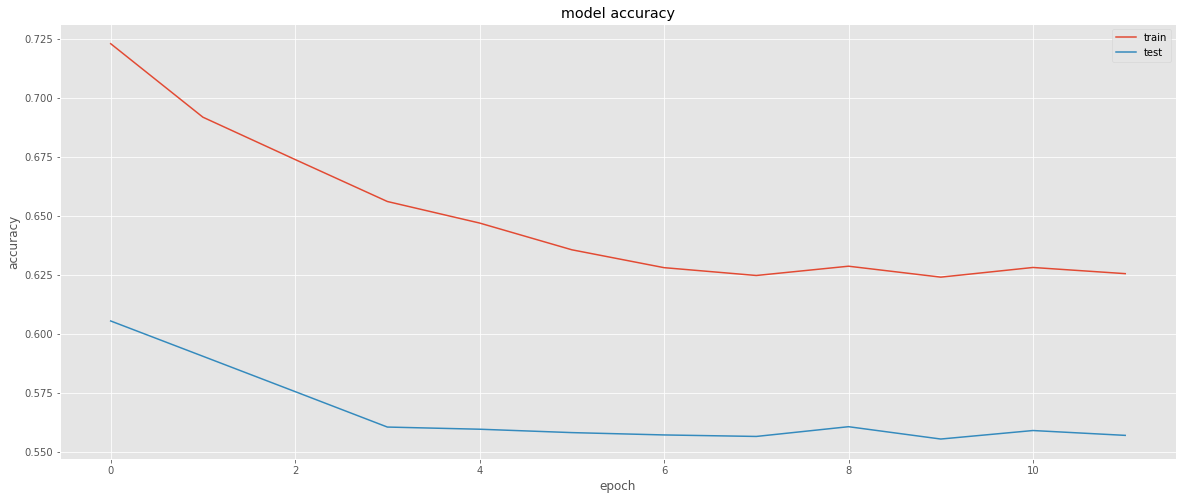

In [149]:
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()


In [150]:
lstm_eval = lstm_model.evaluate(
    test_generator, verbose=0
)
lstm_eval
val_performance['LSTM'] = lstm_model.evaluate(train_generator)
performance['LSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 12s 135ms/step - loss: 0.7710 - mean_absolute_error: 0.6335


In [151]:
predictions_lstm = lstm_model.predict(test_generator)

In [152]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/lstm_model_standard/')

In [153]:
predictions_lstm.shape[0]


617

In [154]:
predictions_lstm


array([[ 3.14677596e-01],
       [ 4.44929063e-01],
       [ 5.95450699e-01],
       [ 5.13655543e-01],
       [ 6.27588987e-01],
       [ 3.14923942e-01],
       [ 2.10658506e-01],
       [ 2.93431520e-01],
       [ 4.54080403e-01],
       [ 4.05420780e-01],
       [ 2.84430504e-01],
       [ 4.19850618e-01],
       [ 4.59117949e-01],
       [ 1.75809681e-01],
       [-2.74518318e-02],
       [-1.58439539e-02],
       [ 7.95124620e-02],
       [ 2.98502088e-01],
       [ 3.47702980e-01],
       [ 1.48848861e-01],
       [ 2.41687268e-01],
       [ 9.64418054e-02],
       [ 5.17300889e-02],
       [-9.32962894e-02],
       [-9.21860039e-02],
       [ 4.48671937e-01],
       [-1.25812799e-01],
       [-1.98654890e-01],
       [-2.24940032e-01],
       [-7.78401196e-02],
       [-4.21094187e-02],
       [-1.37595013e-02],
       [ 1.26078352e-02],
       [ 8.06523710e-02],
       [ 1.17307439e-01],
       [ 1.55744433e-01],
       [ 2.32995842e-02],
       [-2.28160247e-02],
       [ 9.2

In [155]:
y_test


array([-1.78006675e-01,  2.90522982e-01,  4.01932093e-01, -3.79251433e-01,
       -2.99279395e-01, -2.78792655e-01, -2.98110214e-01, -2.81164148e-01,
       -2.22417265e-01, -1.07808395e+00, -8.15801157e-01,  5.79954518e-01,
       -6.86622939e-01, -4.95420527e-01,  5.30510897e-01,  4.63250208e-01,
       -1.25570378e-01,  8.39427469e-01,  1.14431566e+00, -8.61278758e-02,
       -1.55122403e-01, -6.67327547e-02, -6.07852007e-02,  1.09177878e+00,
        4.27697261e-01, -5.62510972e-01,  6.83577733e-02,  6.59699164e-01,
       -5.97099194e-01, -7.06773017e-01, -3.14681106e-01, -7.99520204e-01,
       -5.33956905e-01, -5.62716976e-01, -3.53351252e-01, -3.56915968e-01,
       -2.15191286e-01, -2.60981634e-01,  4.54835917e-01,  3.74158938e-01,
       -1.19796188e-01, -1.05337742e-01, -5.84620349e-01, -2.10494719e-01,
        5.95663698e-01,  3.54550545e-01,  2.65081183e-01, -4.86511378e-01,
        1.44002703e+00, -1.32841472e+00,  4.04121247e-01, -4.74652685e-01,
        2.65321149e-01,  

In [156]:
x_test


array([[-0.22339246, -0.17800668, -0.09350367, ...,  0.04903191,
         0.03529621,  0.05583466],
       [ 0.26046697,  0.29052298,  0.36036737, ...,  0.5736526 ,
         0.52721539,  0.64483744],
       [ 0.30468378,  0.40193209,  0.43489046, ...,  0.69306692,
         0.67560118,  0.72049598],
       ...,
       [-0.27743919, -0.20720092,  0.07324638, ...,  0.66219269,
         0.52804164,  0.52924301],
       [-0.73269987, -0.72525887, -0.52228415, ...,  0.25089596,
         0.28543631,  0.26948637],
       [ 0.34273106,  0.22060855, -0.015185  , ..., -1.57317129,
        -1.71286   , -1.83726913]])

In [157]:
x_test[:, 1:][win_length:]


array([[ 1.0241705 ,  1.22346867,  1.269134  , ...,  1.86237767,
         1.88641523,  1.90663469],
       [ 1.29962917,  1.64645577,  2.07812667, ...,  2.88657627,
         2.82556734,  2.97741047],
       [ 1.25468271,  1.4411265 ,  1.53755633, ...,  2.14727433,
         2.17352658,  2.1890856 ],
       ...,
       [-0.20720092,  0.07324638,  0.07263632, ...,  0.66219269,
         0.52804164,  0.52924301],
       [-0.72525887, -0.52228415, -0.35767027, ...,  0.25089596,
         0.28543631,  0.26948637],
       [ 0.22060855, -0.015185  , -0.18703531, ..., -1.57317129,
        -1.71286   , -1.83726913]])

In [158]:
df_pred_lstm = pd.concat([pd.DataFrame(predictions_lstm),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_lstm


,0,0,1,2,3,4,5,6,7,8,9
0,0.314678,1.024170,1.223469,1.269134,1.416241,1.559921,1.832902,1.893571,1.862378,1.886415,1.906635
1,0.444929,1.299629,1.646456,2.078127,1.965539,2.259432,2.804838,2.824108,2.886576,2.825567,2.977410
2,0.595451,1.254683,1.441127,1.537556,1.730239,1.919608,2.123640,2.166428,2.147274,2.173527,2.189086
3,0.513656,1.428023,1.610747,1.758643,1.849356,2.127451,2.356997,2.334348,2.308937,2.377172,2.436567
4,0.627589,0.593265,0.664491,0.666645,0.833811,0.934638,1.147744,1.203770,1.222829,1.237120,1.261254
...,...,...,...,...,...,...,...,...,...,...,...
612,-0.185439,-0.139950,0.078249,0.131267,0.109520,0.443826,0.594395,0.625473,0.595123,0.671591,0.677167
613,-0.094364,-0.213699,-0.033622,0.061901,0.245970,0.358970,0.528339,0.561508,0.534332,0.523062,0.506839
614,-0.124391,-0.207201,0.073246,0.072636,0.138815,0.501630,0.394346,0.503041,0.662193,0.528042,0.529243
615,-0.153357,-0.725259,-0.522284,-0.357670,-0.218663,0.040778,0.259104,0.292591,0.250896,0.285436,0.269486


In [159]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_lstm)
rev_trans


array([[ 486.63110065,  620.6271022 ,  620.7624344 , ...,  927.7332591 ,
         954.5726793 ,  958.3011009 ],
       [ 512.99743313,  673.9332311 ,  693.4118545 , ..., 1116.021953  ,
        1129.609667  , 1156.273757  ],
       [ 543.46698242,  665.2352967 ,  658.1458805 , ...,  980.1086674 ,
        1008.083826  , 1010.522637  ],
       ...,
       [ 397.75200184,  382.3349317 ,  423.2079867 , ...,  707.0912247 ,
         701.4021671 ,  703.639112  ],
       [ 391.8886502 ,  282.0815485 ,  320.9236669 , ...,  631.478424  ,
         656.1859493 ,  655.6134532 ],
       [ 370.11457549,  465.1236395 ,  408.0196074 , ...,  296.1418579 ,
         283.7481277 ,  266.1014844 ]])

In [160]:
df_final_lstm = df_input[predictions_lstm.shape[0]*-1:]


In [161]:
df_final_lstm.count()


Subcar_6     617
Subcar_7     617
Subcar_9     617
Subcar_10    617
Subcar_11    617
Subcar_13    617
Subcar_15    617
Subcar_16    617
Subcar_17    617
Subcar_18    617
Subcar_19    617
dtype: int64

In [162]:
df_final_lstm['Subcar_13_pred'] = rev_trans[:, 1]
df_final_lstm


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_15,Subcar_16,Subcar_17,Subcar_18,Subcar_19,Subcar_13_pred
Time,,,,,,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,811.741954,879.778381,927.733259,954.572679,958.301101,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,973.822366,1043.245417,1116.021953,1129.609667,1156.273757,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,860.225552,927.711162,980.108667,1008.083826,1010.522637,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,899.140145,957.209486,1009.828698,1046.038718,1056.278846,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,697.484767,758.601345,810.158626,833.558636,838.978546,537.239239
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,605.208229,657.012176,694.761110,728.156577,730.988372,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,594.192730,645.775503,683.585401,700.474125,699.496962,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,571.847882,635.504524,707.091225,701.402167,703.639112,382.334932


Text(0, 0.5, 'Amplitude')

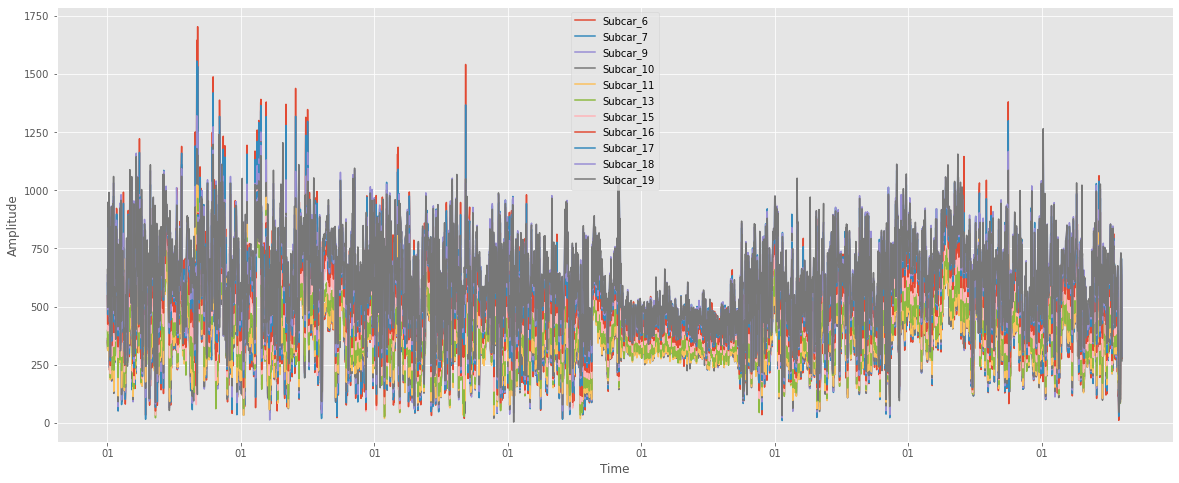

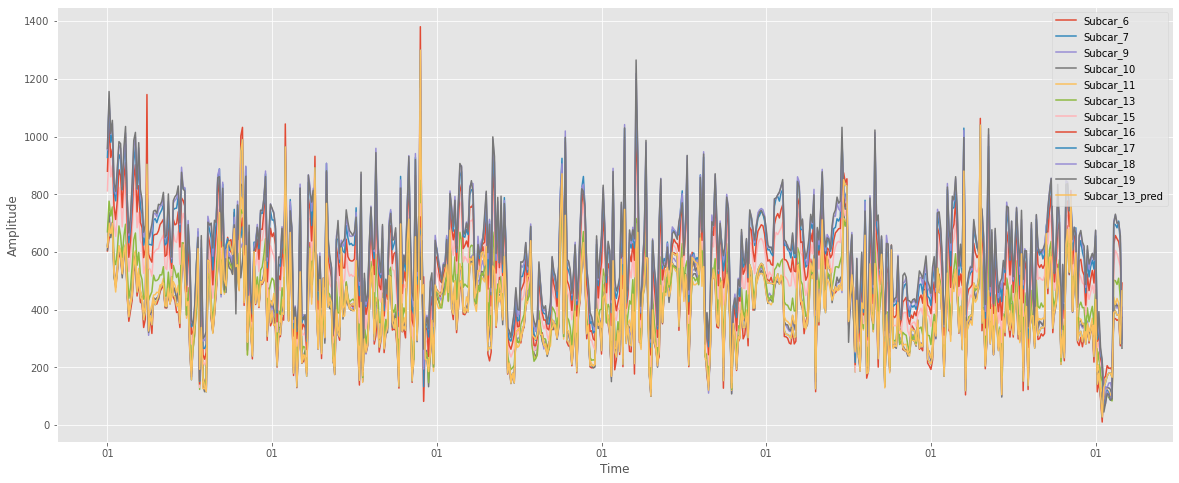

In [163]:
plot_cols = ['Subcar_6', 'Subcar_7', 'Subcar_9',
             'Subcar_10', 'Subcar_11', 'Subcar_13', 'Subcar_15', 'Subcar_16', 'Subcar_17', 'Subcar_18', 'Subcar_19']
plot_features = df_input[plot_cols]
plot_features.index = date_time
_ = plot_features.plot(subplots=False)
plt.ylabel("Amplitude")

df_final_lstm[['Subcar_13', 'Subcar_13_pred']]
df_final_lstm.index = date_time[:617]
_ = df_final_lstm.plot(subplots=False)
plt.ylabel("Amplitude")


In [164]:
gru_model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(
        128, input_shape=(win_length, num_features), return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='linear')
])


In [165]:
cp3 = ModelCheckpoint('../save/gru_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
gru_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [166]:
history_2 = gru_model.fit(
    train_generator, epochs=10,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping
               , cp3])


Epoch 1/10
91/91 [==============================] - 50s 549ms/step - loss: 0.9115 - mean_absolute_error: 0.6962 - val_loss: 0.5705 - val_mean_absolute_error: 0.5660
Epoch 2/10
91/91 [==============================] - 34s 371ms/step - loss: 0.8110 - mean_absolute_error: 0.6541 - val_loss: 0.5706 - val_mean_absolute_error: 0.5692
Epoch 3/10
91/91 [==============================] - 50s 549ms/step - loss: 0.7758 - mean_absolute_error: 0.6381 - val_loss: 0.5684 - val_mean_absolute_error: 0.5687
Epoch 4/10
91/91 [==============================] - 51s 556ms/step - loss: 0.7598 - mean_absolute_error: 0.6308 - val_loss: 0.5614 - val_mean_absolute_error: 0.5660
Epoch 5/10
91/91 [==============================] - 36s 390ms/step - loss: 0.7558 - mean_absolute_error: 0.6287 - val_loss: 0.5874 - val_mean_absolute_error: 0.5928
Epoch 6/10
91/91 [==============================] - 36s 390ms/step - loss: 0.7444 - mean_absolute_error: 0.6281 - val_loss: 0.5742 - val_mean_absolute_error: 0.5768


In [167]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/gru_model_standard/')

In [168]:
gru_eval = gru_model.evaluate(
    test_generator, verbose=0
)
gru_eval
val_performance['BiLSTM'] = lstm_model.evaluate(train_generator)
performance['BiLSTM'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 13s 144ms/step - loss: 0.7710 - mean_absolute_error: 0.6335


In [169]:
predictions_gru = gru_model.predict(test_generator)
predictions_gru

array([[ 4.35153514e-01],
       [ 5.24708092e-01],
       [ 6.37548923e-01],
       [ 6.26300633e-01],
       [ 6.54862106e-01],
       [ 4.95811254e-01],
       [ 3.57969373e-01],
       [ 3.43625665e-01],
       [ 4.23060715e-01],
       [ 4.25648957e-01],
       [ 3.49010974e-01],
       [ 4.36263293e-01],
       [ 4.84760612e-01],
       [ 2.88342565e-01],
       [ 5.05573861e-02],
       [-1.72942877e-03],
       [ 5.82234785e-02],
       [ 3.02805245e-01],
       [ 4.40212220e-01],
       [ 2.92352438e-01],
       [ 3.33112448e-01],
       [ 2.32887805e-01],
       [ 1.91709012e-01],
       [ 6.26909360e-02],
       [ 4.15350534e-02],
       [ 4.78720158e-01],
       [ 1.67589903e-01],
       [ 4.48354371e-02],
       [-1.05863146e-01],
       [-5.38927093e-02],
       [-4.34398800e-02],
       [-3.65956500e-02],
       [-2.58001760e-02],
       [ 2.37883627e-02],
       [ 6.15113825e-02],
       [ 9.88952518e-02],
       [-2.71210372e-02],
       [-8.93776864e-02],
       [ 3.0

In [170]:
predictions_gru.shape[0]


617

In [171]:
predictions_gru

array([[ 4.35153514e-01],
       [ 5.24708092e-01],
       [ 6.37548923e-01],
       [ 6.26300633e-01],
       [ 6.54862106e-01],
       [ 4.95811254e-01],
       [ 3.57969373e-01],
       [ 3.43625665e-01],
       [ 4.23060715e-01],
       [ 4.25648957e-01],
       [ 3.49010974e-01],
       [ 4.36263293e-01],
       [ 4.84760612e-01],
       [ 2.88342565e-01],
       [ 5.05573861e-02],
       [-1.72942877e-03],
       [ 5.82234785e-02],
       [ 3.02805245e-01],
       [ 4.40212220e-01],
       [ 2.92352438e-01],
       [ 3.33112448e-01],
       [ 2.32887805e-01],
       [ 1.91709012e-01],
       [ 6.26909360e-02],
       [ 4.15350534e-02],
       [ 4.78720158e-01],
       [ 1.67589903e-01],
       [ 4.48354371e-02],
       [-1.05863146e-01],
       [-5.38927093e-02],
       [-4.34398800e-02],
       [-3.65956500e-02],
       [-2.58001760e-02],
       [ 2.37883627e-02],
       [ 6.15113825e-02],
       [ 9.88952518e-02],
       [-2.71210372e-02],
       [-8.93776864e-02],
       [ 3.0

In [172]:
df_pred_gru = pd.concat([pd.DataFrame(predictions_gru),
                    pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_gru

,0,0,1,2,3,4,5,6,7,8,9
0,0.435154,1.024170,1.223469,1.269134,1.416241,1.559921,1.832902,1.893571,1.862378,1.886415,1.906635
1,0.524708,1.299629,1.646456,2.078127,1.965539,2.259432,2.804838,2.824108,2.886576,2.825567,2.977410
2,0.637549,1.254683,1.441127,1.537556,1.730239,1.919608,2.123640,2.166428,2.147274,2.173527,2.189086
3,0.626301,1.428023,1.610747,1.758643,1.849356,2.127451,2.356997,2.334348,2.308937,2.377172,2.436567
4,0.654862,0.593265,0.664491,0.666645,0.833811,0.934638,1.147744,1.203770,1.222829,1.237120,1.261254
...,...,...,...,...,...,...,...,...,...,...,...
612,-0.100322,-0.139950,0.078249,0.131267,0.109520,0.443826,0.594395,0.625473,0.595123,0.671591,0.677167
613,-0.036250,-0.213699,-0.033622,0.061901,0.245970,0.358970,0.528339,0.561508,0.534332,0.523062,0.506839
614,-0.004743,-0.207201,0.073246,0.072636,0.138815,0.501630,0.394346,0.503041,0.662193,0.528042,0.529243
615,-0.013954,-0.725259,-0.522284,-0.357670,-0.218663,0.040778,0.259104,0.292591,0.250896,0.285436,0.269486


In [173]:
# To the original format
rev_trans = scaler.inverse_transform(df_pred_gru)
rev_trans


array([[ 511.01860414,  620.6271022 ,  620.7624344 , ...,  927.7332591 ,
         954.5726793 ,  958.3011009 ],
       [ 529.14681283,  673.9332311 ,  693.4118545 , ..., 1116.021953  ,
        1129.609667  , 1156.273757  ],
       [ 551.98877337,  665.2352967 ,  658.1458805 , ...,  980.1086674 ,
        1008.083826  , 1010.522637  ],
       ...,
       [ 421.97186202,  382.3349317 ,  423.2079867 , ...,  707.0912247 ,
         701.4021671 ,  703.639112  ],
       [ 420.10731643,  282.0815485 ,  320.9236669 , ...,  631.478424  ,
         656.1859493 ,  655.6134532 ],
       [ 407.83691374,  465.1236395 ,  408.0196074 , ...,  296.1418579 ,
         283.7481277 ,  266.1014844 ]])

In [174]:
df_final_gru = df_input[predictions_gru.shape[0]*-1:]

In [175]:
df_final_gru['Subcar_13_pred'] = rev_trans[:, 1]
df_final_gru


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_15,Subcar_16,Subcar_17,Subcar_18,Subcar_19,Subcar_13_pred
Time,,,,,,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,811.741954,879.778381,927.733259,954.572679,958.301101,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,973.822366,1043.245417,1116.021953,1129.609667,1156.273757,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,860.225552,927.711162,980.108667,1008.083826,1010.522637,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,899.140145,957.209486,1009.828698,1046.038718,1056.278846,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,697.484767,758.601345,810.158626,833.558636,838.978546,537.239239
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,605.208229,657.012176,694.761110,728.156577,730.988372,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,594.192730,645.775503,683.585401,700.474125,699.496962,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,571.847882,635.504524,707.091225,701.402167,703.639112,382.334932


In [176]:

conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(2,),
                           activation='relu', input_shape=(win_length, num_features)),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])


In [177]:
cp4 = ModelCheckpoint('../save/conv_model_standard/', save_best_only=True)
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=2,
    mode='min'
)
conv_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                  optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                   metrics=[tf.keras.metrics.MeanAbsoluteError()])


In [178]:
history_3 = conv_model.fit(
    train_generator, epochs=15,
    validation_data=test_generator,
    shuffle=False,
    callbacks=[early_stopping, cp4])


Epoch 1/15
91/91 [==============================] - 1s 12ms/step - loss: 1.1333 - mean_absolute_error: 0.7814 - val_loss: 0.6630 - val_mean_absolute_error: 0.6314
Epoch 2/15
91/91 [==============================] - 1s 6ms/step - loss: 1.0973 - mean_absolute_error: 0.7762 - val_loss: 0.6664 - val_mean_absolute_error: 0.6304
Epoch 3/15
91/91 [==============================] - 1s 6ms/step - loss: 1.0999 - mean_absolute_error: 0.7756 - val_loss: 0.6641 - val_mean_absolute_error: 0.6305


In [179]:
from tensorflow.keras.models import load_model
gru_model = load_model('../save/conv_model_standard/')


In [180]:
conv_eval = conv_model.evaluate(
    test_generator, verbose=0
)
conv_eval
val_performance['CONV'] = lstm_model.evaluate(train_generator)
performance['CONV'] = lstm_model.evaluate(test_generator, verbose=0)


91/91 [==============================] - 12s 136ms/step - loss: 0.7710 - mean_absolute_error: 0.6335


In [181]:
predictions_conv = conv_model.predict(test_generator)
predictions_conv

array([[[-0.04792669],
        [-0.03980245],
        [-0.05646863],
        ...,
        [-0.12446553],
        [-0.06788069],
        [-0.06927527]],

       [[-0.03980245],
        [-0.05646863],
        [-0.1187245 ],
        ...,
        [-0.06788069],
        [-0.06927527],
        [-0.1432088 ]],

       [[-0.05646863],
        [-0.1187245 ],
        [-0.11070022],
        ...,
        [-0.06927527],
        [-0.1432088 ],
        [-0.21851306]],

       ...,

       [[-0.02334466],
        [-0.36148232],
        [-0.32239172],
        ...,
        [-0.49936146],
        [-0.1192129 ],
        [-0.1561044 ]],

       [[-0.36148232],
        [-0.32239172],
        [-0.11409906],
        ...,
        [-0.1192129 ],
        [-0.1561044 ],
        [-0.11323538]],

       [[-0.32239172],
        [-0.11409906],
        [-0.3194084 ],
        ...,
        [-0.1561044 ],
        [-0.11323537],
        [-0.14334582]]], dtype=float32)

In [182]:
df_pred_conv = pd.concat([pd.DataFrame(predictions_gru),
                         pd.DataFrame(x_test[:, 1:][win_length:])], axis=1)
df_pred_conv


,0,0,1,2,3,4,5,6,7,8,9
0,0.435154,1.024170,1.223469,1.269134,1.416241,1.559921,1.832902,1.893571,1.862378,1.886415,1.906635
1,0.524708,1.299629,1.646456,2.078127,1.965539,2.259432,2.804838,2.824108,2.886576,2.825567,2.977410
2,0.637549,1.254683,1.441127,1.537556,1.730239,1.919608,2.123640,2.166428,2.147274,2.173527,2.189086
3,0.626301,1.428023,1.610747,1.758643,1.849356,2.127451,2.356997,2.334348,2.308937,2.377172,2.436567
4,0.654862,0.593265,0.664491,0.666645,0.833811,0.934638,1.147744,1.203770,1.222829,1.237120,1.261254
...,...,...,...,...,...,...,...,...,...,...,...
612,-0.100322,-0.139950,0.078249,0.131267,0.109520,0.443826,0.594395,0.625473,0.595123,0.671591,0.677167
613,-0.036250,-0.213699,-0.033622,0.061901,0.245970,0.358970,0.528339,0.561508,0.534332,0.523062,0.506839
614,-0.004743,-0.207201,0.073246,0.072636,0.138815,0.501630,0.394346,0.503041,0.662193,0.528042,0.529243
615,-0.013954,-0.725259,-0.522284,-0.357670,-0.218663,0.040778,0.259104,0.292591,0.250896,0.285436,0.269486


In [183]:
# To the original format
rev_trans_conv = scaler.inverse_transform(df_pred_conv)
rev_trans_conv


array([[ 511.01860414,  620.6271022 ,  620.7624344 , ...,  927.7332591 ,
         954.5726793 ,  958.3011009 ],
       [ 529.14681283,  673.9332311 ,  693.4118545 , ..., 1116.021953  ,
        1129.609667  , 1156.273757  ],
       [ 551.98877337,  665.2352967 ,  658.1458805 , ...,  980.1086674 ,
        1008.083826  , 1010.522637  ],
       ...,
       [ 421.97186202,  382.3349317 ,  423.2079867 , ...,  707.0912247 ,
         701.4021671 ,  703.639112  ],
       [ 420.10731643,  282.0815485 ,  320.9236669 , ...,  631.478424  ,
         656.1859493 ,  655.6134532 ],
       [ 407.83691374,  465.1236395 ,  408.0196074 , ...,  296.1418579 ,
         283.7481277 ,  266.1014844 ]])

In [184]:
df_final_conv = df_input[predictions_conv.shape[0]*-1:]


In [185]:
df_final_conv['Subcar_13_pred'] = rev_trans_conv[:, 1]
df_final_conv


C:\Users\Owner\anaconda3\envs\Tensorflow210\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Subcar_6,Subcar_7,Subcar_9,Subcar_10,Subcar_11,Subcar_13,Subcar_15,Subcar_16,Subcar_17,Subcar_18,Subcar_19,Subcar_13_pred
Time,,,,,,,,,,,,
1970-01-01 00:00:01.641599862,603.491508,620.627102,620.762434,606.564918,616.652252,669.809675,811.741954,879.778381,927.733259,954.572679,958.301101,620.627102
1970-01-01 00:00:01.641599862,647.734514,673.933231,693.411855,736.315829,700.157839,776.095999,973.822366,1043.245417,1116.021953,1129.609667,1156.273757,673.933231
1970-01-01 00:00:01.641599862,656.558451,665.235297,658.145880,649.616040,664.386936,724.461869,860.225552,927.711162,980.108667,1008.083826,1010.522637,665.235297
1970-01-01 00:00:01.641599862,703.184186,698.779651,687.278692,685.075178,682.495421,756.042327,899.140145,957.209486,1009.828698,1046.038718,1056.278846,698.779651
1970-01-01 00:00:01.641599862,547.154457,537.239239,524.756134,509.934309,528.109837,574.801705,697.484767,758.601345,810.158626,833.558636,838.978546,537.239239
...,...,...,...,...,...,...,...,...,...,...,...,...
1970-01-01 00:00:01.641600115,369.043358,395.349213,424.067212,424.067212,418.001196,500.225949,605.208229,657.012176,694.761110,728.156577,730.988372,395.349213
1970-01-01 00:00:01.641600115,362.663756,381.077420,404.853060,412.941885,438.744800,487.332535,594.192730,645.775503,683.585401,700.474125,699.496962,381.077420
1970-01-01 00:00:01.641600115,366.771046,382.334932,423.207987,414.663719,422.454731,509.008841,571.847882,635.504524,707.091225,701.402167,703.639112,382.334932


Text(0, 0.5, 'Amplitude')

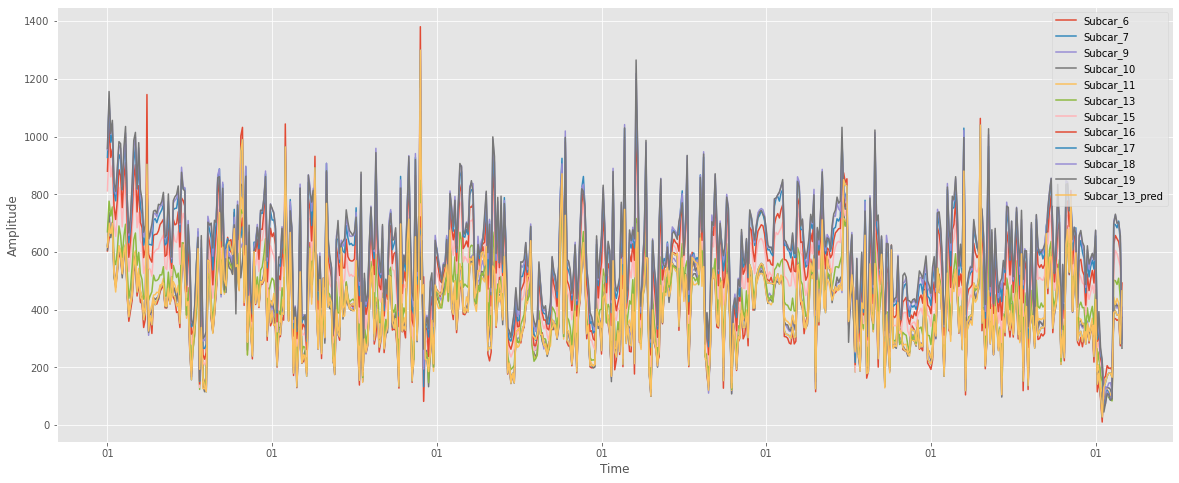

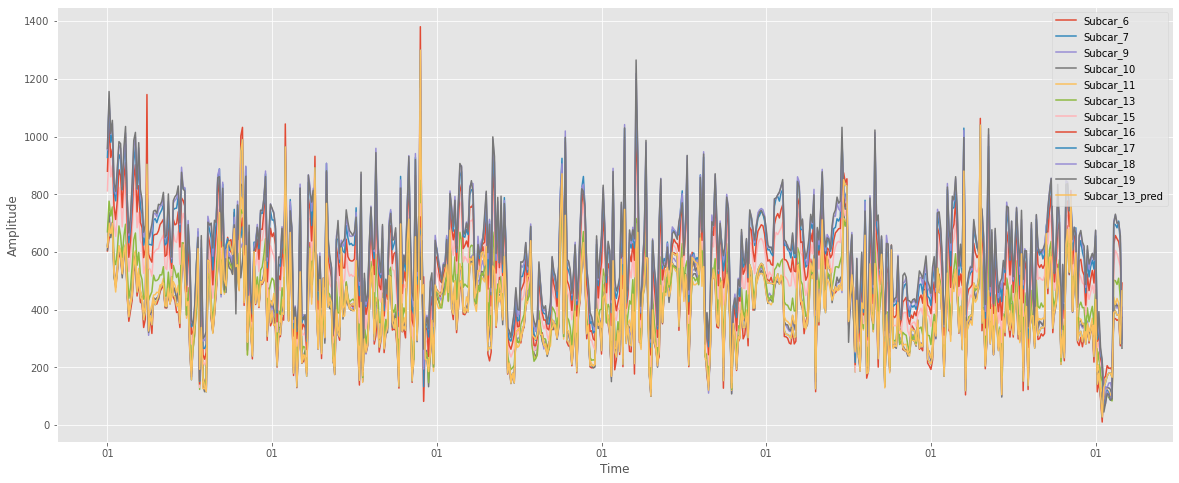

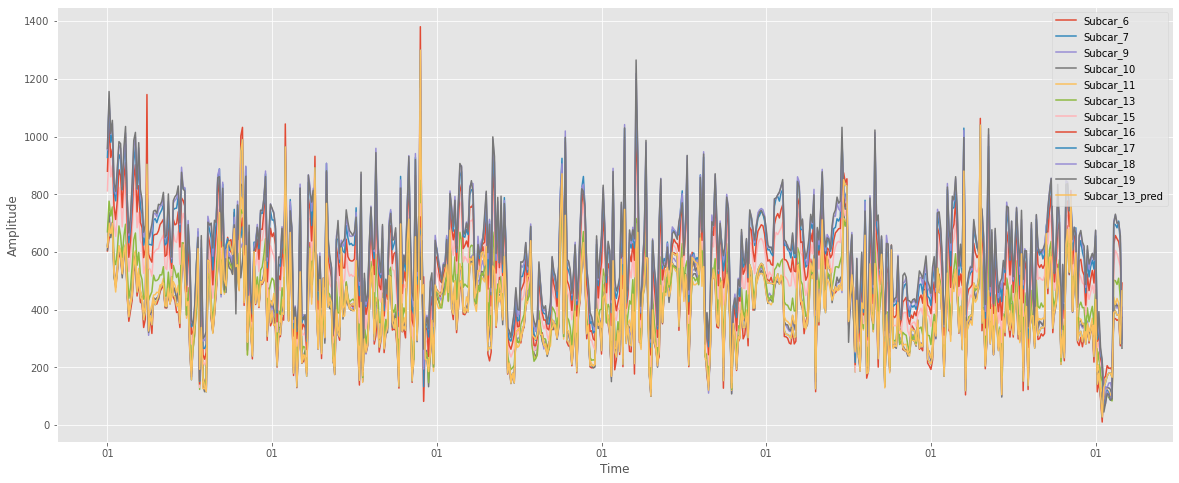

In [186]:

df_final_gru[['Subcar_13', 'Subcar_13_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude")

df_final_gru[['Subcar_13', 'Subcar_13_pred']]
df_final_gru.index = date_time[:617]
_ = df_final_gru.plot(subplots=False)
plt.ylabel("Amplitude")

df_final_conv[['Subcar_13', 'Subcar_13_pred']]
df_final_conv.index = date_time[:617]
_ = df_final_conv.plot(subplots=False)
plt.ylabel("Amplitude")


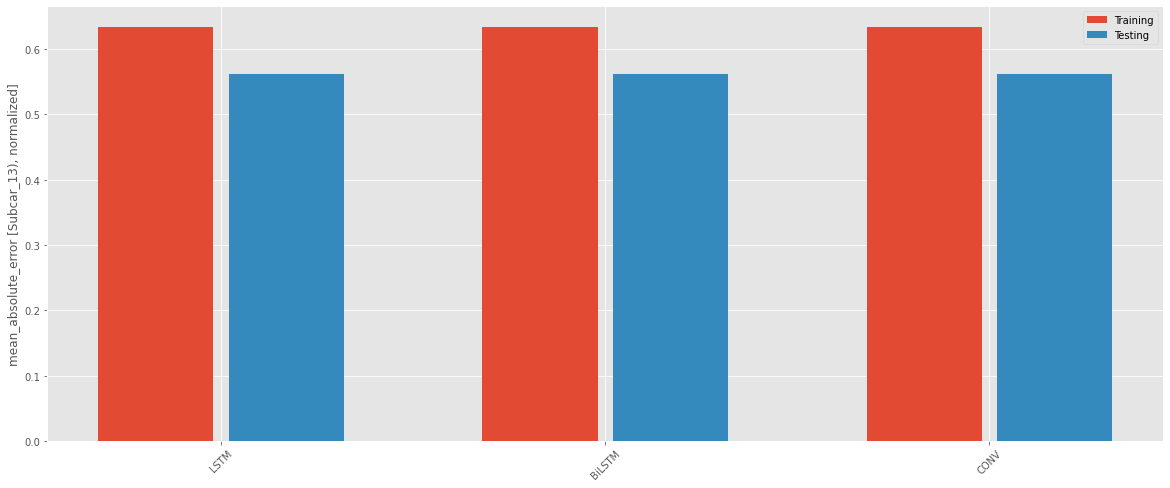

In [187]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = lstm_model.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [Subcar_13), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Training')
plt.bar(x + 0.17, test_mae, width, label='Testing')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()


In [188]:
for name, value in performance.items():
  print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.5618
BiLSTM      : 0.5618
CONV        : 0.5618


In [189]:
# df_final_conv[['Subcar_7', 'Subcar_7_pred']].plot()
for name, value in val_performance.items():
      print(f'{name:12s}: {value[1]:0.4f}')


LSTM        : 0.6335
BiLSTM      : 0.6335
CONV        : 0.6335
